<a href="https://colab.research.google.com/github/PeiYauWeng/MODQPSO_training_FNN/blob/main/MODQPSO_training_NN_with_new_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

In [ ]:
class Mesh_Swarm(object):
  def __init__(self, num_particles, num_mesh, threshold):
    self.num_particles = num_particles
    self.num_mesh = num_mesh
    self.threshold = threshold

  def get_gbest_index(self, num_archiving_particles, crowd_archiving_particles):
    get_probability_chosen = np.divide(1.0,(np.power(crowd_archiving_particles,3)))
    get_probability_chosen = get_probability_chosen/np.sum(get_probability_chosen)
    chosen_index = np.multiply(get_probability_chosen, np.random.uniform(0,1, (self.num_mesh, num_archiving_particles)))
    chosen_index = np.sum(chosen_index, axis=0)
    chosen_index = np.argsort(chosen_index)[np.int32(num_archiving_particles*0.9)-1:]
    chosen_index = np.random.choice(chosen_index,size=(self.num_particles),replace=True)
    return chosen_index
    
  def clear_archives(self, num_archiving_particles, crowd_archiving_particles):
    get_probability_chosen = crowd_archiving_particles/np.sum(crowd_archiving_particles)
    rest_index = np.multiply(get_probability_chosen, np.random.uniform(0,1, (self.num_mesh, num_archiving_particles)))
    rest_index = np.sum(rest_index, axis=0)
    rest_index = np.argsort(rest_index)[:self.threshold]
    return rest_index

In [ ]:
class Pareto(object):
  def __init__(self, fitness):
    self.fitness = fitness
    self.dominant_value = len(self.fitness)-1
  
  def find_optimals(self):
    judge_table = self.fitness[:,np.newaxis,:] < self.fitness
    delete_index = np.sign(np.sum(judge_table, axis=2))
    delete_index = np.sum(delete_index, axis=1)
    index_nondominant_particles = np.argwhere(delete_index>=self.dominant_value).ravel()
    return index_nondominant_particles.astype(np.int)

In [ ]:
class Initialization(object):
  def __init__(self, model_shape):
    self.model_shape = model_shape
    self.tmp_cumsum = np.multiply(model_shape[:-1],model_shape[1:])
    self.dim_per_particle = np.add(np.sum(self.tmp_cumsum), np.sum(self.model_shape[1:]))

  def init_locations_all_particles(self, minimum, maximum, num_particles):
    global locations_all_particles
    locations_all_particles = np.array(np.random.uniform(minimum, maximum, size=(num_particles, self.dim_per_particle)), dtype=np.float32)
  
  def operation_table(self):
    global bias4locations_capture_table
    global weight4locations_capture_table
    bias4locations_capture_table = np.cumsum(np.append([0], self.model_shape[1:], axis=0), dtype=np.int)
    weight4locations_capture_table = np.add(np.hstack(([0], np.cumsum(self.tmp_cumsum, dtype=np.int))), bias4locations_capture_table[-1])
    #return bias4locations_capture_table, weight4locations_capture_table

In [ ]:
class MODQPSO_NN_operations(object):
  def __init__(self, num_particles, num_neurons_input_layer):
    self.num_particles = num_particles
    self.num_neurons_input_layer = num_neurons_input_layer
    self.previous_judge_table = np.ones(shape=(self.num_particles,1, self.num_neurons_input_layer))
    self.smallest_bias = np.zeros(shape=(self.num_particles,1,1))
    self.deleted_neurons_table = np.empty(shape=(self.num_particles,1,0),dtype=int)
    self.weight_connection_table = np.empty(shape=(self.num_particles,1,0),dtype=int)
    self.shape_table = np.ones(shape=(self.num_particles,1,1), dtype=np.int)

  def get_smallest_bias(self, bias_end_point):
    global locations_all_particles
    smallest_bias_all_particles = np.min(np.abs(locations_all_particles[:,:bias_end_point]), axis=1, keepdims=2)
    self.smallest_bias = smallest_bias_all_particles[:,np.newaxis,:]
    #print(self.smallest_bias)

  def NN_structure_collection(self, judge_table):
    self.deleted_neurons_table = np.dstack((self.deleted_neurons_table, judge_table))
    self.weight_connection_table = np.dstack((self.weight_connection_table, np.sum(judge_table, axis=2)))


  def Dense(self, input_array, num_neurons_output, ID):
    global locations_all_particles
    global weight4locations_capture_table
    global bias4locations_capture_table
    layer_weight = np.reshape(locations_all_particles[:,weight4locations_capture_table[ID]:weight4locations_capture_table[ID+1]], 
                              newshape=(self.num_particles, input_array.shape[-1], num_neurons_output))
    layer_bias = locations_all_particles[:,np.newaxis,bias4locations_capture_table[ID]:bias4locations_capture_table[ID+1]]
    judge_table = (np.abs(layer_weight)>=self.smallest_bias)
    final_judge_table = np.sign(np.sum(judge_table, axis=2))
    final_judge_table = np.multiply(self.previous_judge_table, final_judge_table[:,np.newaxis,:])
    self.NN_structure_collection(final_judge_table)
    input_array = np.multiply(input_array, final_judge_table)
    output_array = np.add( np.matmul(input_array, layer_weight), layer_bias)
    self.previous_judge_table = np.sign(np.sum(judge_table, axis=1, keepdims=3))
    return output_array

  def get_deleted_weight_connections_table(self):
    self.weight_connection_table = np.dstack((self.weight_connection_table, np.multiply(self.previous_judge_table.shape[-1], self.shape_table)))
    return np.sum(np.multiply(self.weight_connection_table[:,:,:-1], self.weight_connection_table[:,:,1:]), axis=2)

  def get_deleted_neurons_table(self):
    self.deleted_neurons_table = np.dstack((self.deleted_neurons_table, np.ones(shape=(self.previous_judge_table.shape[0],1,self.previous_judge_table.shape[-1]))))
    return self.deleted_neurons_table

  def get_num_deleted_neurons_table(self):
    return np.sum(self.deleted_neurons_table, axis=2)

  def restart_NN(self):
    self.deleted_neurons_table = np.empty(shape=(self.num_particles,1,0),dtype=int)
    self.weight_connection_table = np.empty(shape=(self.num_particles,1,0),dtype=int)
    self.previous_judge_table = np.ones(shape=(self.num_particles,1, self.num_neurons_input_layer))
    self.smallest_bias = np.zeros(shape=(self.num_particles,1,1))  

In [ ]:
class Evaluation(object):
  def __init__(self, model_shape, target_value, batch_size):
    self.num_all_neurons = np.sum(model_shape)
    self.num_all_weights = np.sum(np.multiply(model_shape[:-1], model_shape[1:]))
    self.target_value = target_value
    self.batch_size = batch_size
    self.guide_table = np.arange(0, batch_size, 1)

  def cross_entropy(self, y_predict):
    #exp_scores = np.exp(y_predict)
    #probs = np.divide(exp_scores, np.sum(exp_scores, axis=2, keepdims=3))
    logprobs = np.multiply(-1, np.log(y_predict[:,self.guide_table, self.target_value[self.guide_table]]))
    #print(logprobs)
    loss = np.divide(np.sum(logprobs, axis=1, keepdims=2), self.batch_size)
    #print(loss)
    #print(loss.shape)
    return loss

  def error_rate(self, y_predict):
    error = np.subtract(1.0, (np.argmax(y_predict, axis=2)==self.target_value).mean(axis=1, keepdims=2))
    #print(error.shape)
    return error

  def NN_structure_adjustment(self, deleted_weight_connections_table, num_deleted_neurons_table):
    ratio_active_connection = np.divide(deleted_weight_connections_table, self.num_all_weights)
    ratio_active_node = np.divide(num_deleted_neurons_table, self.num_all_neurons)
    return np.multiply(np.power(ratio_active_connection,0.5), np.power(ratio_active_node, 2))

In [ ]:
class Dynamic_Node_Deletion(object):
  def __init__(self, model_shape):
    self.model_shape = np.asarray(model_shape)
    self.num_layers = self.model_shape.shape[0]-1
    #self.deleted_neurons_table = deleted_neurons_table
    self.bias_end_index = np.sum(model_shape[1:])
    self.front_guide_table = np.append([0],np.cumsum(self.model_shape[:-1]),axis=0)
    self.next_guide_table = np.cumsum(self.model_shape)

  def rebuild_NN_weights(self, rebuild_index, deleted_neurons_table):
    global locations_all_particles
    num_particles = rebuild_index.shape[0]
    start_point = self.bias_end_index
    for i in range(self.num_layers):
      tmp_deleted_weights_table = np.matmul(deleted_neurons_table[:,:,self.front_guide_table[i]:self.front_guide_table[i+1]].transpose(0,2,1), 
                                            deleted_neurons_table[:,:,self.next_guide_table[i]:self.next_guide_table[i+1]])
      num_weights = self.model_shape[i]*self.model_shape[i+1]
      locations_all_particles[rebuild_index,start_point:(start_point+num_weights)] = np.multiply(locations_all_particles[rebuild_index, start_point:(start_point+num_weights)], 
                                                                                                     tmp_deleted_weights_table.reshape(num_particles,num_weights))
      start_point += num_weights

In [ ]:
class MOQDPSO(object):
  def __init__(self, num_particles, model_shape, num_objects, iterations, num_mesh, maximum, minimum, threshold, dtype):
    global locations_all_particles
    self.num_particles = num_particles
    self.dim_per_particle = np.add(np.sum(np.multiply(model_shape[:-1],model_shape[1:])), np.sum(model_shape[1:]))
    self.alpha = 1.0
    self.iterations = iterations
    self.maximum = maximum
    self.minimum = minimum
    self.num_mesh = num_mesh
    self.threshold = threshold
    self.dtype = dtype
    
    self.random_index = np.empty(0)
    self.index_current_optimals = np.empty(0)
    self.pbest_parameters = np.zeros(shape=(self.num_particles, self.dim_per_particle), dtype=self.dtype)
    self.fitness_values = np.multiply(np.inf, np.ones(shape=(self.num_particles, num_objects), dtype=self.dtype))
    self.archiving_locations = locations_all_particles
    self.archiving_fitness = np.multiply(np.inf, np.ones(shape=(self.num_particles, num_objects), dtype=self.dtype))
    self.gbest_parameters = np.zeros(shape=(self.num_particles, self.dim_per_particle), dtype=self.dtype)
    self.outer_gbest_parameters = np.zeros(shape=(self.num_particles, self.dim_per_particle), dtype=self.dtype)

  def get_crowd_archiving_particles(self):
    tmp = np.multiply(self.num_mesh, np.subtract(self.archiving_locations, self.minimum)) 
    distance = np.subtract(self.maximum, self.minimum)
    ID_archiving_particles = np.divide(tmp, distance).astype(np.int32)
    judge_table = (ID_archiving_particles[:,np.newaxis,:] == ID_archiving_particles)
    judge_table = (np.sum(judge_table, axis=2)==ID_archiving_particles.shape[1])
    crowd_archiving_particles = np.sum(judge_table, axis=1)
    return crowd_archiving_particles

  def get_outer_gbest_parameters(self):
    pair_table=np.sum(np.power(np.subtract(self.gbest_parameters, self.gbest_parameters[:,np.newaxis,:]), 2), axis=2)
    pair_table=np.argmax(pair_table, axis=1)
    self.outer_gbest_parameters = self.gbest_parameters[pair_table]

  def co_learning_method(self, learning_rate):
    global locations_all_particles
    judge_table = np.random.rand(self.num_particles,1)>learning_rate
    invert_table = np.invert(judge_table)
    random_index = np.random.choice(np.arange(0,self.num_particles,1),size=(self.num_particles), replace=True)
    self_pair_table = (random_index==np.arange(0,self.num_particles,1))
    random_index = np.add(np.multiply(random_index, np.invert(self_pair_table)), 
                np.int32(np.multiply(np.multiply(random_index,self_pair_table),np.random.rand(self.num_particles))))
    random_index[0] = np.add(np.multiply(self_pair_table[0], np.random.choice(np.arange(0,self.num_particles,1))),
                 np.multiply(np.invert(self_pair_table[0]), random_index[0]))
    dis_pbest2locations = np.add(np.multiply(np.subtract(locations_all_particles, self.pbest_parameters),judge_table),
                   np.multiply(np.subtract(locations_all_particles, self.pbest_parameters[random_index]), invert_table))
    dis_pbest2locations = np.abs(dis_pbest2locations).astype(self.dtype)
    return dis_pbest2locations

  def get_rebuild_index(self, current_fitness_values):
    judge_table = np.sign(np.subtract(current_fitness_values, self.fitness_values))
    t1=np.argwhere(np.sum((judge_table == 1)+(judge_table == 0), axis=1)==3).ravel()
    t2=np.argwhere(np.sum((judge_table == -1)+(judge_table == 0), axis=1)==3).ravel()
    tmp_random_index = np.delete(np.arange(0,self.num_particles,1), np.hstack((t1.astype(np.int),t1.astype(np.int))), axis=0)
    np.random.shuffle(tmp_random_index)
    self.random_index = np.unique(np.hstack((tmp_random_index[:tmp_random_index.shape[0]//2],t2)))
    pareto = Pareto(current_fitness_values)
    self.index_current_optimals = pareto.find_optimals()
    rebuild_index = np.unique(np.hstack((self.random_index, self.index_current_optimals)), axis=0)
    return rebuild_index

  def fitness(self, current_fitness_values):
    global locations_all_particles
    '''get current pbest parameters, archiving locations, archiving firness, gbest parameters and best fittness'''
    self.pbest_parameters[self.random_index] = locations_all_particles[self.random_index]
    self.fitness_values[self.random_index] = current_fitness_values[self.random_index]
    optimal_locations = locations_all_particles[self.index_current_optimals]
    optimal_fitness = current_fitness_values[self.index_current_optimals]
    self.archiving_locations = np.concatenate((self.archiving_locations, optimal_locations), axis=0)
    self.archiving_fitness = np.concatenate((self.archiving_fitness, optimal_fitness), axis=0)
    
    pareto = Pareto(self.archiving_fitness)
    index_archiving_optimals = pareto.find_optimals()
    self.archiving_locations = self.archiving_locations[index_archiving_optimals]
    self.archiving_fitness = self.archiving_fitness[index_archiving_optimals]

    CD_selection = Mesh_Swarm(self.num_particles, self.num_mesh, self.threshold)
    rest_index = CD_selection.clear_archives(self.archiving_locations.shape[0], self.get_crowd_archiving_particles())
    self.archiving_locations = self.archiving_locations[rest_index]
    self.archiving_fitness = self.archiving_fitness[rest_index]
    
    gbest_index = CD_selection.get_gbest_index(self.archiving_locations.shape[0], self.get_crowd_archiving_particles())
    self.gbest_parameters = self.archiving_locations[gbest_index]
    gbest_fitness = self.archiving_fitness[gbest_index]
    
    return gbest_fitness[np.argmin(np.mean(gbest_fitness, axis=1))]

  def update(self, num_iteration):
    global locations_all_particles
    #calculate the distance between particle locations and mbest
    co_learning_rate = np.power(np.subtract(1, np.power((num_iteration/self.iterations), 1/2)), 2)
    dis_co_pbest2locations = self.co_learning_method(co_learning_rate)
    self.get_outer_gbest_parameters()

    #update random_point
    a = np.array(np.random.uniform(0, 1, size=(self.num_particles,1)),dtype=self.dtype)#covergence coefficient
    P1_pbest_parameters = np.multiply(a, self.pbest_parameters)
    tmp = np.multiply(np.subtract(1,a), self.gbest_parameters)
    P1_pbest_parameters = np.add(P1_pbest_parameters, tmp)
    a = np.array(np.random.uniform(0, 1, size=(self.num_particles,1)),dtype=self.dtype)#covergence coefficient
    P2_pbest_parameters = np.multiply(a, self.pbest_parameters)
    tmp = np.multiply(np.subtract(1,a), self.outer_gbest_parameters)
    P2_pbest_parameters = np.add(P2_pbest_parameters, tmp)

    #update double contract expand coefficient: alpha, beta
    self.alpha = self.dtype(0.5*(self.iterations-num_iteration)/self.iterations + 0.5)
    tmp = np.sign(np.subtract(np.random.uniform(0,1,size=(self.num_particles,1)), 0.5))
    self.alpha = np.multiply(self.alpha, tmp)

    #update particle locations
    ln_one2u = np.log(np.divide(1, np.random.uniform(size=(self.num_particles, 1))))
    tmp = np.multiply(self.alpha, np.multiply(ln_one2u, dis_co_pbest2locations))
    beta = np.random.rand(self.num_particles, 1)
    locations_all_particles = np.multiply(1/2, np.add(np.add(P1_pbest_parameters, P2_pbest_parameters), 
                          np.multiply(beta, np.subtract(P1_pbest_parameters,P2_pbest_parameters))))
    
    #the paticle locations must be in [minimum, maximum] after updating
    locations_all_particles = np.divide(np.subtract(locations_all_particles,np.min(locations_all_particles, axis=0)), 
                   np.ptp(locations_all_particles, axis=0))
    locations_all_particles = np.add(np.multiply(locations_all_particles,(self.maximum-self.minimum)), self.minimum)

In [ ]:
'''Define a model here'''
from functools import partial
class Model(MODQPSO_NN_operations):
  def __init__(self, num_particles, model_shape):
    super().__init__(num_particles, model_shape[0])
    self.dense_0 = partial(super().Dense,num_neurons_output=model_shape[1], ID=0)
    self.dense_1 = partial(super().Dense,num_neurons_output=model_shape[2], ID=1)
  
  def call(self, input):
    super().get_smallest_bias(bias4locations_capture_table[-1])
    output = self.dense_0(input)
    output = np.tanh(output)
    output = self.dense_1(output)
    # sotfmax
    output = np.exp(output)
    output = np.divide(output, np.sum(output, axis=2, keepdims=3))
    return output

  def get_model_info(self):
    return super().get_deleted_weight_connections_table(), super().get_deleted_neurons_table(), super().get_num_deleted_neurons_table()

  def restart_NN(self):
    super().restart_NN()

In [ ]:
import matplotlib.pyplot as plt

def plot(results):
  # draw a diagram
  x = []
  y = []
  for i in range(len(results)):
    x.append(i + 1)
    y.append(results[i])
  plt.plot(x,y)
  plt.xlabel('Number of iteration',size = 15)
  plt.ylabel('Value of CV',size = 15)
  plt.title('MOQDPSO_IRIS parameter optimization')
  plt.show()

In [ ]:
from sklearn.datasets import load_iris

data = load_iris()
x = data.data
y = data.target

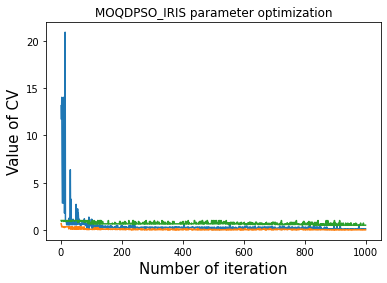

Training time:  10.630736351013184  seconds


In [ ]:
import time
model_shape = [4, 20 ,3]
num_samples = 150
num_particles = 50
num_ojects = 3
iterations = 1000
num_mesh = 10
threshold = 150
maximum = 30.0
minimum = -15.0
initalize = Initialization(model_shape)
initalize.init_locations_all_particles(minimum, maximum, num_particles)
initalize.operation_table()
moqdpso = MOQDPSO(num_particles, model_shape, num_ojects, iterations, num_mesh, maximum, minimum, threshold, np.float32)
model = Model(num_particles, model_shape)
evaluation = Evaluation(model_shape, y, batch_size=150)
rule = Dynamic_Node_Deletion(model_shape)
best_fitness_history=[]
#evaluation_threshold = np.array([0.1, 0.025, 0.7])
start_time = time.time()
for i in range(iterations):
  y_pred = model.call(x)
  DWCT, DNT, NDNT = model.get_model_info()
  current_fitness_table = np.hstack((evaluation.cross_entropy(y_pred), evaluation.error_rate(y_pred), evaluation.NN_structure_adjustment(DWCT, NDNT)))
  rebuild_index = moqdpso.get_rebuild_index(current_fitness_table)
  rule.rebuild_NN_weights(rebuild_index, DNT[rebuild_index])
  best_fitness = moqdpso.fitness(current_fitness_table)
  best_fitness_history.append(best_fitness)
  moqdpso.update(i+1)
  model.restart_NN()
end_time = time.time()

plot(best_fitness_history)
print('Training time: ',(end_time-start_time),' seconds')

In [ ]:
best_fitness_history[900:]

[array([0.12909297, 0.01333333, 0.50612767]),
 array([0.09504356, 0.01333333, 0.72845783]),
 array([0.11282718, 0.01333333, 0.6490425 ]),
 array([0.12909297, 0.01333333, 0.50612767]),
 array([0.11423305, 0.04      , 0.50612767]),
 array([0.62552046, 0.06666667, 0.44237354]),
 array([0.12909297, 0.01333333, 0.50612767]),
 array([0.11423305, 0.04      , 0.50612767]),
 array([0.11423305, 0.04      , 0.50612767]),
 array([0.11832624, 0.03333333, 0.50612767]),
 array([0.09504356, 0.01333333, 0.72845783]),
 array([0.11423305, 0.04      , 0.50612767]),
 array([0.12909297, 0.01333333, 0.50612767]),
 array([0.12909297, 0.01333333, 0.50612767]),
 array([0.04563978, 0.00666667, 1.        ]),
 array([0.11832624, 0.03333333, 0.50612767]),
 array([0.62552046, 0.06666667, 0.44237354]),
 array([0.11423305, 0.04      , 0.50612767]),
 array([0.11282718, 0.01333333, 0.6490425 ]),
 array([0.12909297, 0.01333333, 0.50612767]),
 array([0.11423305, 0.04      , 0.50612767]),
 array([0.09504356, 0.01333333, 0.